# **AI Coursework**
----
Add a description here

### Libraries | Helper functions | GPU check
---
>Import all the libraries for training, testing and validating the AI.

In [1]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision.models as models

import time

In [2]:
# imshow helper function for displaying images
def customimshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# percentage helper function
def percentage(value, total):
  return 100 * value / total

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
gpu_info = torch.cuda.get_device_name(0)
print('GPU being used is a ' + gpu_info)

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

GPU being used is a Tesla K80
CUDA is available. Training on GPU.


### Import the dataset
---
This section will import the dataset from Google Drive and unzip the contents to a new folder inside the colab

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip dataset folder 
!unzip '/content/gdrive/MyDrive/UNI/Year_3/AI/DataSet-new.zip' > /dev/null

### Using the dataset
---
This section will use the dataset loaded from eariler and re-size and crop the images and convert them to tensor.

For training, the images will be randomly rotated and flip with a colour jitter added to make training for the AI harder

In [4]:
# Change directory
%cd /content/

# Directory to dataset
data_dir = 'DataSet - new'

# Variables
image_resize = 300
image_crop = 224
mean_normalize = [0.485, 0.456, 0.406]  #[0.485, 0.456, 0.406]
std_normalize = [0.229, 0.224, 0.225]   #[0.229, 0.224, 0.225]
batch_size = 8

# Training transforms with random flips, rotation and colour jitter
#train_transform = transforms.Compose([transforms.Resize(image_resize),
                                      #transforms.RandomRotation(5),
                                      #transforms.CenterCrop(image_crop),
                                      #transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.5, hue = 0.5),
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.ToTensor(),
                                      #transforms.Normalize(mean_normalize, std_normalize)])

# Training transforms with random flips, rotation and colour jitter
train_transform = transforms.Compose([transforms.Resize(image_resize),
                                      transforms.RandomRotation(5),
                                      transforms.CenterCrop(image_crop),
                                      transforms.Grayscale(num_output_channels = 3),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_normalize, std_normalize)])

# Validation and testing transform 
transform = transforms.Compose([transforms.Resize(image_resize),
                                transforms.CenterCrop(image_crop),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_normalize, std_normalize)])

# Choose the training, validation and test datasets
train_data = datasets.ImageFolder(data_dir + '/Training', transform = train_transform)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform = transform)
test_data = datasets.ImageFolder(data_dir + '/Testing', transform = transform)

# prepare the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle = True)

/content


### Display content from dataset
---
This section will display the first 4 images from the dataset in a batch with corresponding labels

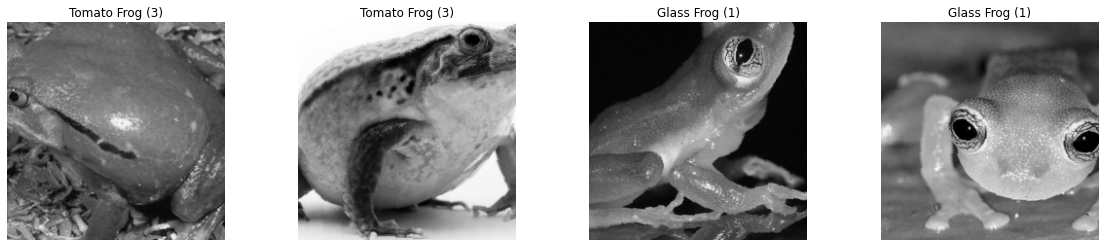

In [6]:
# Update this dictonary if new species are used
frog_list = {0 : 'Desert Rain Frog ', 1 : 'Glass Frog ', 2 : 'Red Eye Tree Frog ', 3 : 'Tomato Frog '}

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize = (20, 4), ncols = 4)
for i in range(4):
    ax = axes[i]
    customimshow(images[i], ax = ax, normalize = True)

    if labels[i].item() == 0: # Desert Rain Frog
      ax.set_title(frog_list[0] + '(' + str(labels[i].item()) + ')')

    if labels[i].item() == 1: # Glass Frog
      ax.set_title(frog_list[1] + '(' + str(labels[i].item()) + ')')

    if labels[i].item() == 2: # Red Eye Tree Frog
      ax.set_title(frog_list[2] + '(' + str(labels[i].item()) + ')')

    if labels[i].item() == 3: # Tomato Frog
      ax.set_title(frog_list[3] + '(' + str(labels[i].item()) + ')')


### ResNet18
---
This section will use the pretrained ResNet18 library to train the network

In [5]:
# ResNet18 requires an image input size of 3x224x224 and normalised using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

# load a pre-trained ResNet network with 18 layers
model = models.resnet18(pretrained = True)

#model = models.torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

# # if we use the following code the pre-trained weights are frozen and we only update the final layer
# for param in model.parameters():
#     param.requires_grad = False

num_classes = 4
num_ftrs = model.fc.in_features             # Gets the number of inputs for the final layer of the network
model.fc = nn.Linear(num_ftrs, num_classes) # Replace the final layer so that the output is number of classes

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

#print(model)

In [6]:
criterion = nn.CrossEntropyLoss() # specify loss function (cross entropy loss)
optimizer = optim.Adam(model.parameters(), lr = 0.001) # specify optimiser (Adam optimiser) and learning rate = 0.001

#### Train CNN
---

In [ ]:
start_time = time.time()

# Number of epochs to train the model
n_epochs = 100

# Initialise tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Create empty lists to store the training and validation losses
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
   
    # validate the model
    model.eval() # prep model for evaluation
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    # store the training and validation losses for later visualisation
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.2f} \tValidation Loss: {:.2f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.2f} --> {:.2f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') # save in google drive
        valid_loss_min = valid_loss

print("Model took {:.2f} minutes to train" .format((time.time() - start_time) / 60))

Epoch: 1 	Training Loss: 1.42 	Validation Loss: 40.52
Validation loss decreased (inf --> 40.52).  Saving model ...
Epoch: 2 	Training Loss: 0.98 	Validation Loss: 2.59
Validation loss decreased (40.52 --> 2.59).  Saving model ...
Epoch: 3 	Training Loss: 0.61 	Validation Loss: 1.63
Validation loss decreased (2.59 --> 1.63).  Saving model ...
Epoch: 4 	Training Loss: 0.68 	Validation Loss: 1.20
Validation loss decreased (1.63 --> 1.20).  Saving model ...
Epoch: 5 	Training Loss: 0.57 	Validation Loss: 1.61
Epoch: 6 	Training Loss: 0.51 	Validation Loss: 1.96
Epoch: 7 	Training Loss: 0.44 	Validation Loss: 1.80
Epoch: 8 	Training Loss: 0.49 	Validation Loss: 5.10
Epoch: 9 	Training Loss: 0.51 	Validation Loss: 1.67
Epoch: 10 	Training Loss: 0.39 	Validation Loss: 1.66
Epoch: 11 	Training Loss: 0.46 	Validation Loss: 0.60
Validation loss decreased (1.20 --> 0.60).  Saving model ...
Epoch: 12 	Training Loss: 0.28 	Validation Loss: 0.85
Epoch: 13 	Training Loss: 0.37 	Validation Loss: 0.83


### Training & Validation losses over time
---
A graph is drawn to showcase the losses for both training and validation

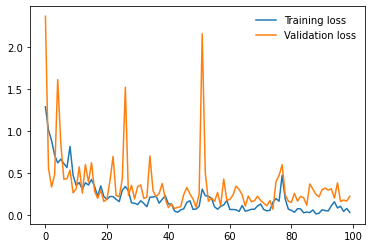

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

### Testing
---

In [7]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug_gray _87.pt')) # resnet18_model_fine_tune_aug

<All keys matched successfully>

In [10]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if train_on_gpu:  # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
    
    output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
    loss = criterion(output, target) # calculate the loss
    test_loss += loss.item() * data.size(0) # update test loss 
    _, pred = torch.max(output, 1) # convert output probabilities to predicted class
    correct = np.squeeze(pred.eq(target.data.view_as(pred))) # compare predictions to true label
    for i in range(len(target)): # calculate test accuracy for each object class
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

# change value here to number of classes
for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: \t %2d%% (%2d/%2d)' % (
            str(frog_list[i]) + str(i), percentage(class_correct[i], class_total[i]),
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)')

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.569599

Test Accuracy of Desert Rain Frog 0: 	 68% (13/19)
Test Accuracy of Glass Frog 1: 	 81% (13/16)
Test Accuracy of Red Eye Tree Frog 2: 	 95% (19/20)
Test Accuracy of Tomato Frog 3: 	 100% (15/15)

Test Accuracy (Overall): 85% (60/70)


### Visualize the results
---
Show the results from the test with an image that was tested, what class the AI predicted and what the actual class was

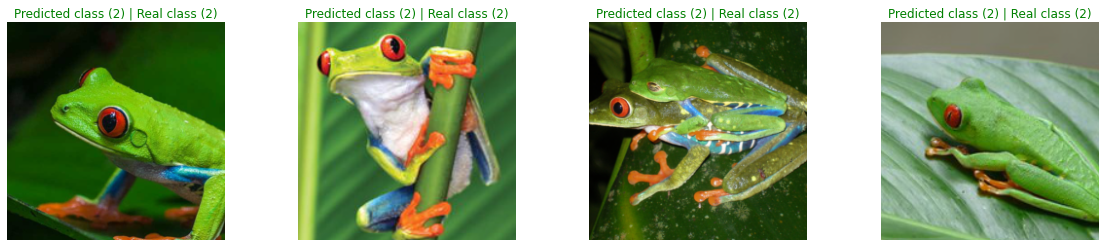

In [11]:
def colouredText(text, value_1, value_2):
  text = ("green" if value_1 == value_2 else "red") 
  return text

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the first 4 images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(20, 4), ncols = 4)

for i in range(4):
    ax = axes[i]
    customimshow(images.cpu()[i], ax, normalize = True)
    
    color = ''
    ax.set_title("{} ({}) {} {} ({})".format('Predicted class', str(preds[i].item()), "|", "Real class", str(labels[i].item())), color = colouredText(color, preds[i], labels[i])) 

### SmoothGradCAM++
---
This section uses SmoothGradCAM++ to view where the network is looking when identifying an image

In [12]:
# Clone SmoothGradCAM++ repo
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

fatal: destination path 'SmoothGradCAMplusplus' already exists and is not an empty directory.


In [8]:
# Change directory
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [9]:
#Import libraries for SmoothGradCAM++
import cam

import skimage.transform
from PIL import Image

from torchvision.utils import save_image

from torch.cuda import device

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

from matplotlib.pyplot import imshow


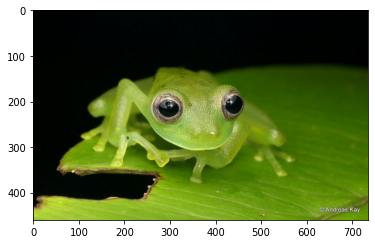

In [10]:
# Preview the image from the dataset
image = Image.open('/content/DataSet - new/Testing/Glass Frog/90a5c90ae06eda5cb8ae9b3e268952f2.jpg')
imshow(image)

In [11]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(mean_normalize, std_normalize)
preprocess = transforms.Compose( [transforms.ToTensor(), normalize] )

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

device = torch.device("cuda:0" if train_on_gpu else "cpu")
tensor = tensor.to(device)

In [12]:
target_layer = model.layer4[1].conv2

wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples = 25, stdev_spread = 0.15)

cam, idx = wrapped_model(tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 2	 probability 0.9501000046730042


In [13]:
print(idx2label[idx])

great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


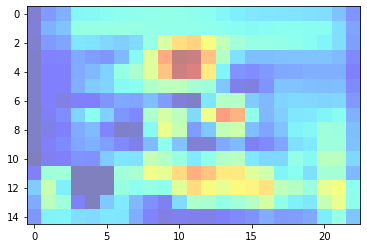

In [14]:
# visualize only cam #cam.squeeze().numpy()
imshow(cam.cpu().squeeze().numpy(), alpha = 0.5, cmap = 'jet')

In [15]:
# reverse normalization for display
img = reverse_normalize(tensor)

heatmap = visualize(img, cam.cpu())

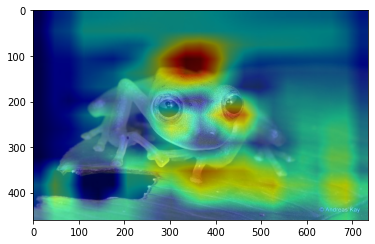

In [16]:
save_image(heatmap, '/content/SmoothGradCAMplusplus/sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)